In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm
from scipy.special import erf
plt.style.use('../InstitutionalInvestmentsALM/MNRAS_stylesheet')

In [196]:
# Helper functions
# Gaussian PDF
def gauss_pdf(x, mu,var):
    sigma = np.sqrt(var)
    return norm(scale=sigma, loc=mu).pdf(x)

# Gaussian CDF
def gauss_cdf(x,mu,sigma):
    return 0.5*(1+erf((x-mu)/(sigma*np.sqrt(2))))

def gauss_icdf(x,mu,sigma):
    return norm.ppf(x,loc=mu,scale=sigma)


def KS_test(returns, cdf1, cdf2):
    p1 = kstest(returns, cdf1)[1]
    p2 = kstest(returns, cdf2)[1]
    return p1,p2

def load_timeseries():
    # Get filenames using glob
    fnames = glob('./timeseries/*csv')
    for f in fnames:
        newdf = pd.read_csv(f)[['Date','Close']]
        newdf = newdf.set_index('Date')
        newdf.index = pd.to_datetime(newdf.index)
        newdf.columns = [f.split('/')[-1].split('.csv')[0]]
        try:
            df = df.join(newdf)
        except:
            df = newdf
    df = df.dropna()
    return df

def plot_timeseries():
    # First plot of all timeseries
    (df / df.iloc[0]*100).plot(lw=1)
    plt.legend(frameon=1)
    plt.ylabel('Normalized stock index price')
    plt.tight_layout()
    plt.savefig('Prices.pdf',bbox_inches='tight')
    
# VaR estimation using variance-covariance matrix
class dataconversion():
    def __init__(self):
        return
    
    def to_log_ret(self, df):
        """Convert prices to log returns"""
        log_ret = np.log(df/df.shift(1))
        return log_ret.iloc[1:,:]
    
def qq_plot():
    
    def order(data, sample_size):
        qq = np.ones([sample_size, 2])
        np.random.shuffle(data)
        qq[:, 0] = np.sort(data[0:sample_size])
        qq[:, 1] = np.sort(np.random.normal(size = sample_size))
        return qq
    
    for stock in stocks:
        measurements = returns[stock]
        qq = order(measurements/np.std(measurements), len(measurements))
        plt.scatter(qq[:,1],qq[:,0],s=0.8,label=stock)
    plt.xlabel('Theoretical quantiles')    
    plt.ylabel('Sample quantiles')
    plt.legend(frameon=1)
    plt.plot([-4,4],[-4,4],color='black',lw=0.5,ls='--')
    plt.tight_layout()
    plt.savefig('qq_plot.pdf',bbox_inches='tight')
    plt.show()
    
def CDFs():
    # Plot CDFs to check normality
    fig,axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(6,3.4))
    axes = axes.flatten()
    for i,stock in enumerate(stocks):
        empirical_CDF = ECDF(returns[stock])
        ax = axes[i]
        ax.plot(empirical_CDF.x,empirical_CDF.y,lw=1,color='tomato',label='ECDF')
        x = np.linspace(empirical_CDF.x[1],empirical_CDF.x[-2], 1000)
        fitted_cdf = gauss_cdf(x, model.means_[0,i], np.sqrt(model.covars_[0,i,i]))
        ax.plot(x, fitted_cdf,color='black',lw=0.7,ls='--',label=r'$\mathcal{N}$-CDF')
        ax.set_xlim(-0.07,0.07)
        ax.legend(frameon=1)
    for i in [3,4,5]:
        axes[i].set_xlabel('Return')
    for i in [0,3]:
        axes[i].set_ylabel('CDF')
    plt.tight_layout()
    plt.savefig('CDF_comparison.pdf', bbox_inches='tight')
    plt.show()


In [137]:
df = load_timeseries()

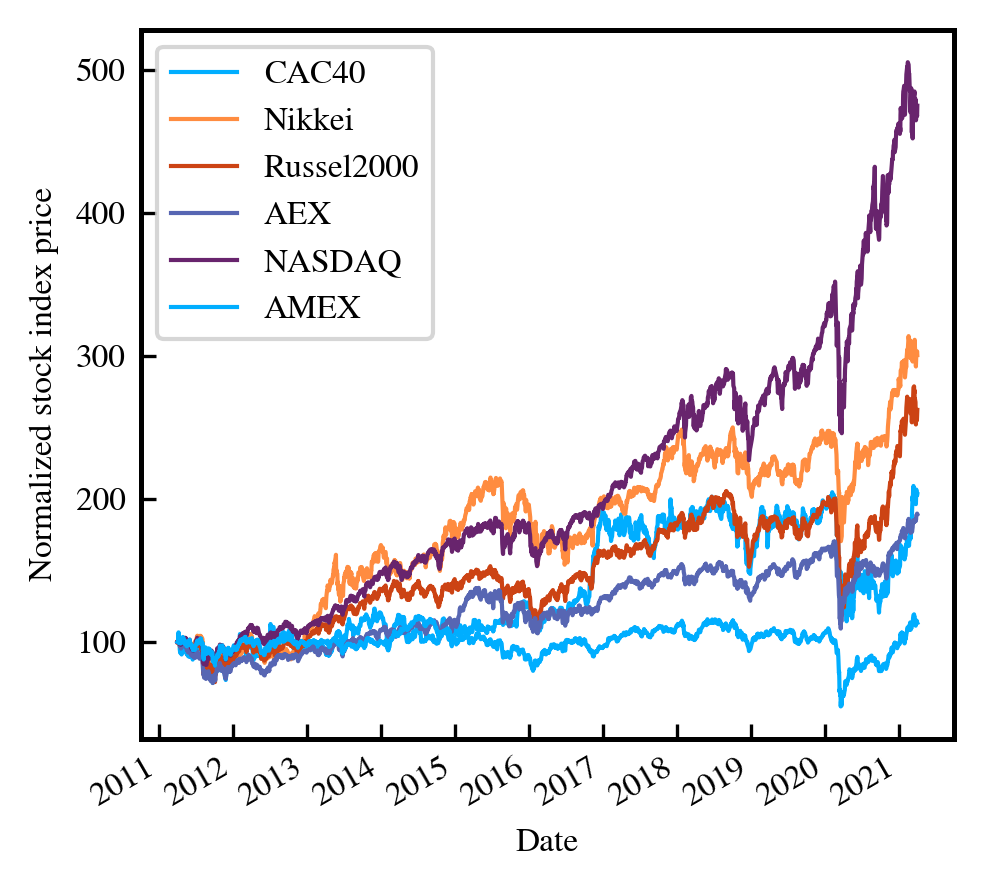

In [120]:
plot_timeseries()

In [210]:
# Convert prices to log returns
DC = dataconversion()
returns = DC.to_log_ret(df)
stocks = df.columns

In [77]:
from hmmlearn import hmm
model = hmm.GaussianHMM(n_components=1, covariance_type="full")
model.fit(returns)

GaussianHMM(covariance_type='full')

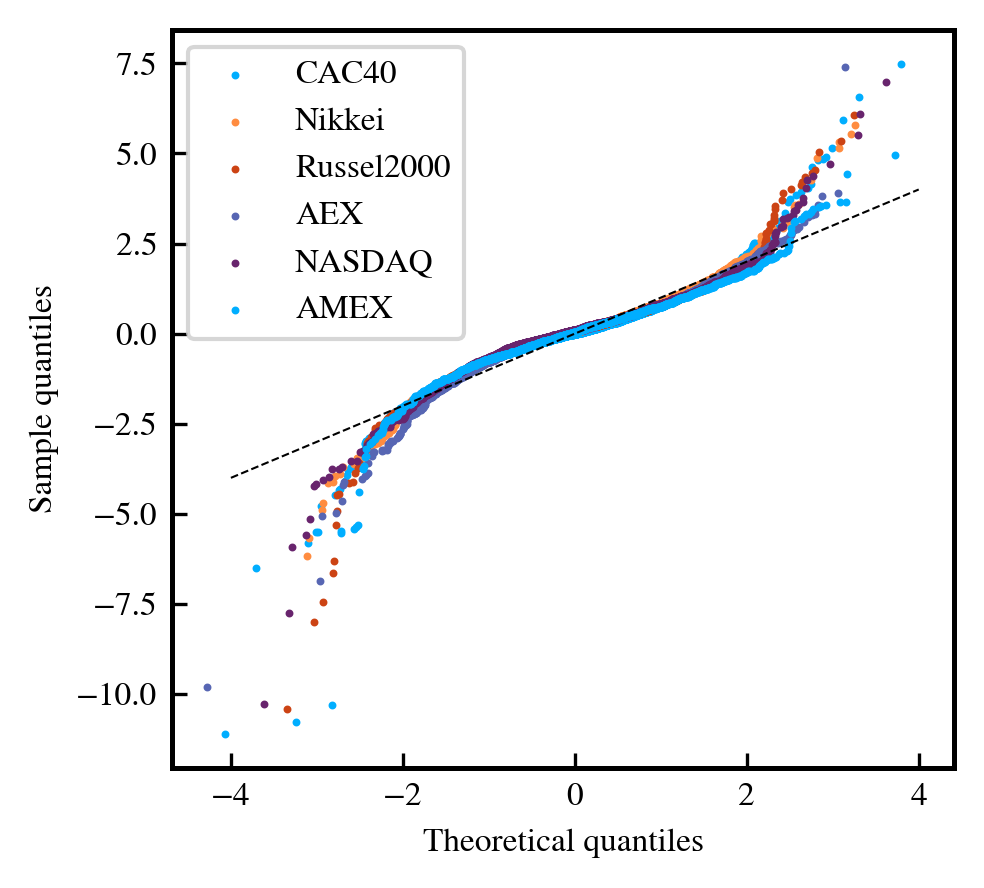

In [138]:
qq_plot()

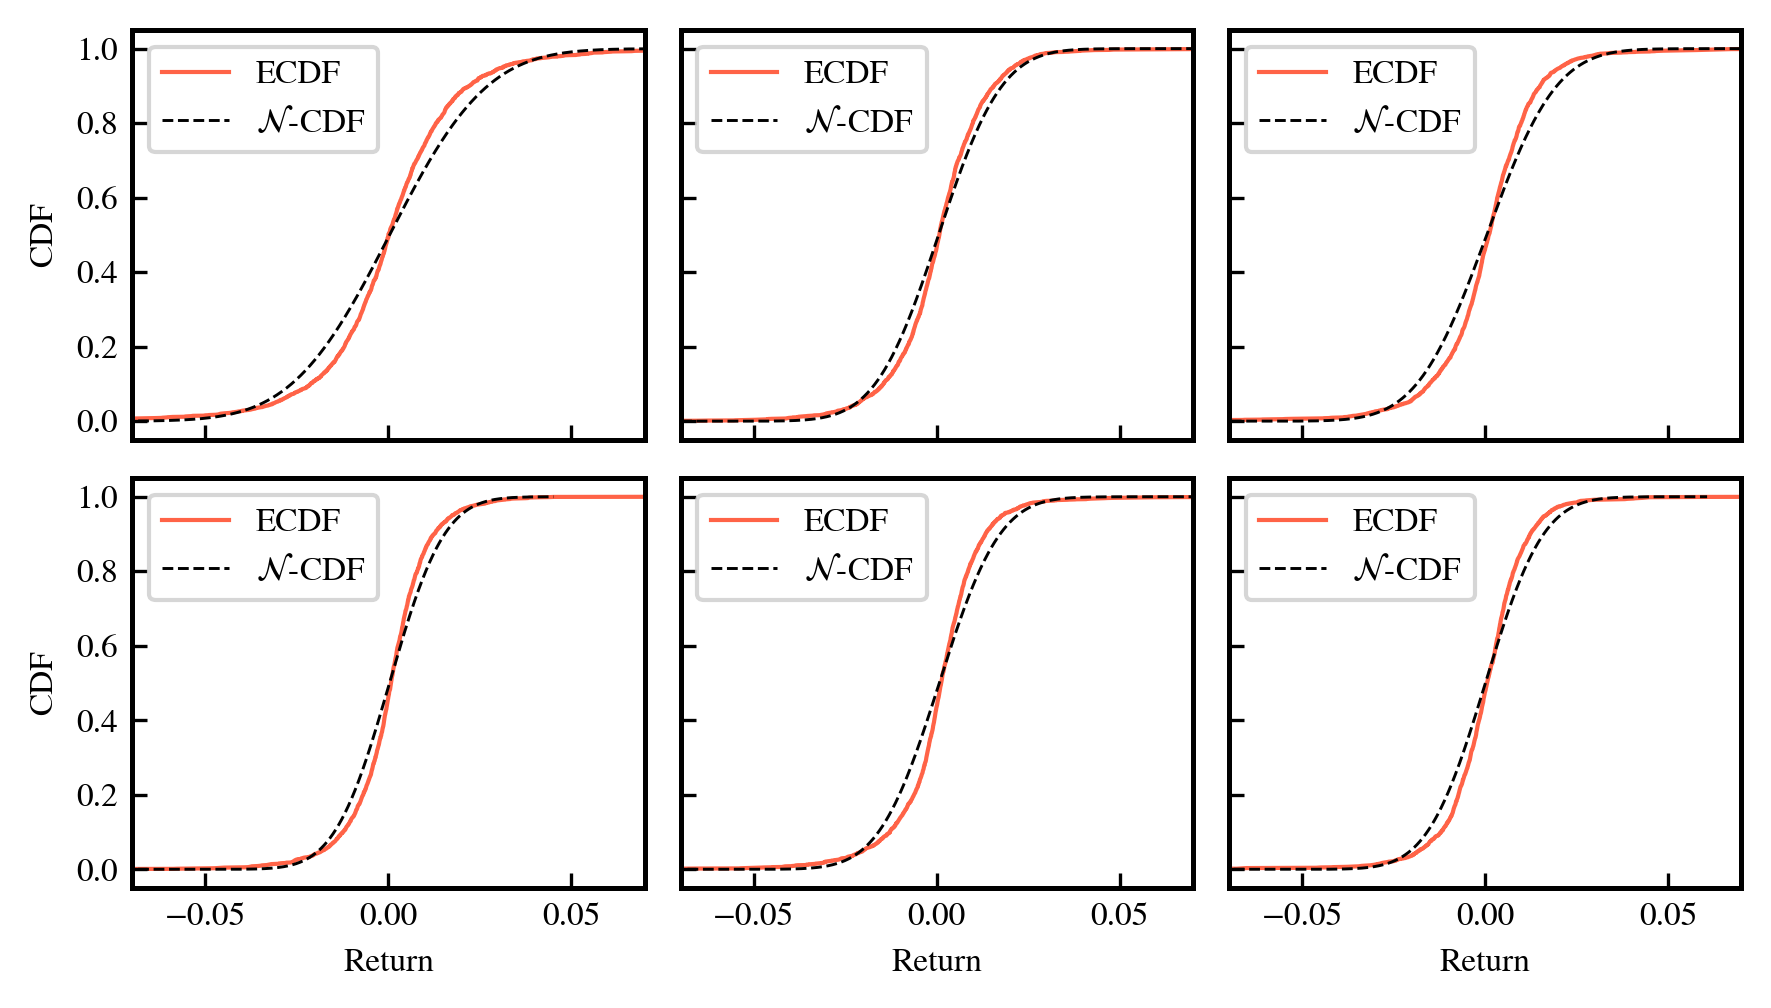

In [197]:
CDFs()

In [260]:
# Estimate covariance matrix
# Option 1: normal covariance matrix
covmat1 = returns.cov()
# Option 2: Ledoit Wolf shrinkage
from sklearn.covariance import LedoitWolf
covmat2 = LedoitWolf().fit(returns)
covmat2 = pd.DataFrame(covmat2.covariance_,index=covmat1.index, columns = covmat1.columns)

In [273]:
# Estimate covariance matrix over first two years
init_covmat = returns.loc[:'2013-03'].cov()
covmats = np.zeros((1+len(returns.loc['2013-03':]), len(stocks), len(stocks)))
covmats[0,:,:] = init_covmat
# Iteratively update covmat
theta=0.04
for i,(date, X) in enumerate(returns.loc['2013-03':].iterrows()):
    X = X.values
    X = X - returns.mean().values
    X = X.reshape(-1,1)
    covmats[i+1] = theta * covmats[i] + (1-theta) * np.dot(X,X.T)

In [297]:
# Now estimate VaR 
alpha = 0.01
sigmas = np.array([np.sqrt(np.diag(covmats[w,:,:])) for w in range(len(covmats))])
VaR = returns.mean().values + norm.ppf(1-alpha)*sigmas
ES  = returns.mean().values + 1/alpha * norm.pdf(norm.ppf(alpha))*sigmas

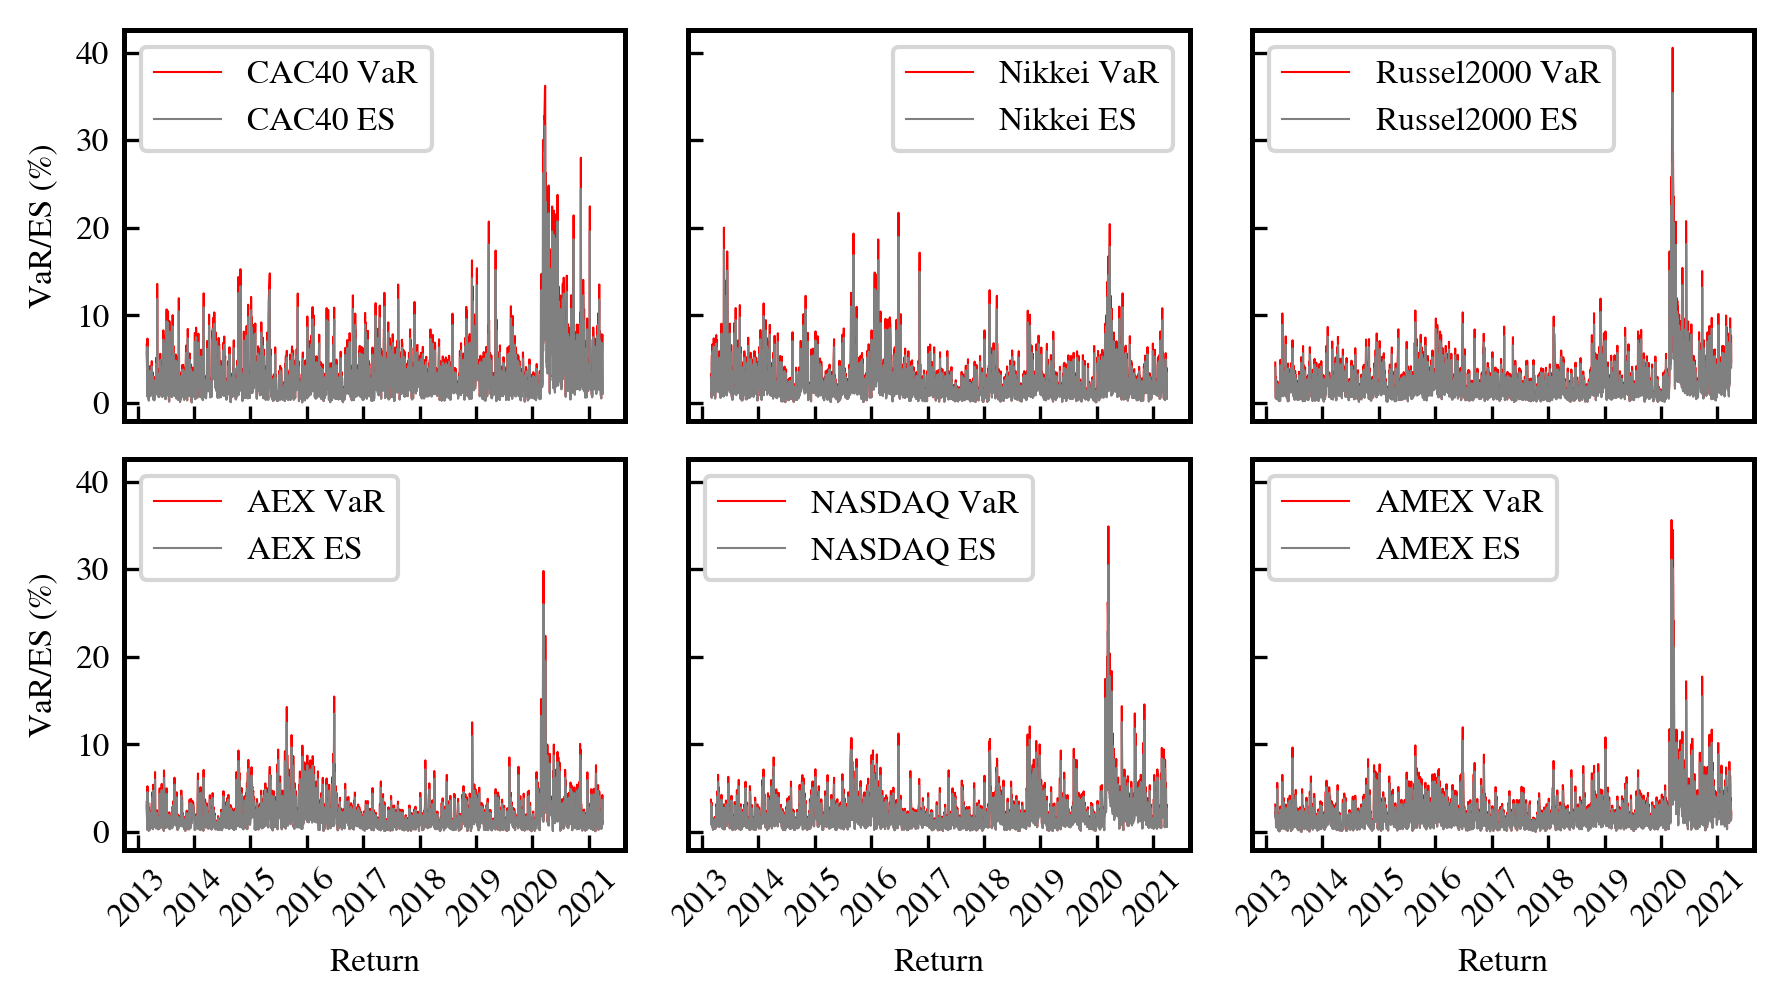

In [309]:
# Plot CDFs to check normality
fig,axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(6,3.4))
axes = axes.flatten()
for i,stock in enumerate(stocks):
    var = VaR[:-1,i]*100
    es  = ES[:-1,i]*100
    ax = axes[i]
    ax.plot(returns.loc['2013-03':].index, es,lw=0.5,color='red',label=stock+' VaR')
    ax.plot(returns.loc['2013-03':].index, var,lw=0.5,color='grey',label=stock+' ES')
    
    ax.legend(frameon=1)
    
for i in [3,4,5]:
    axes[i].set_xlabel('Return')
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45 )
for i in [0,3]:
    axes[i].set_ylabel('VaR/ES (%)')
plt.tight_layout()
plt.savefig('ES_VaR_covariance.pdf', bbox_inches='tight')
plt.show()